## AAUtoSig Markdown
This document is a runthrough of our autoencoder model.
Firstly we initialise our installed packages

In [14]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp
import matplotlib
import matplotlib.pyplot as plt
from datetime import date
import copy


from functions import simulate_counts, plotsigs, cosine_HA
from AAUtoSig_init import get_lr


## Initialise the autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model.

In [15]:
class AAUtoSig(torch.nn.Module):
    def __init__(self, feature_dim, latent_dim):
    
        super().__init__()
        
        # Building an linear encoder
        # 96 => dim1 => dim2
        self.enc1 = torch.nn.Linear(feature_dim, latent_dim, bias = False)
          
        # Building an linear decoder 
        # dim ==> 96
        self.dec1 = torch.nn.Linear(latent_dim, feature_dim, bias = False)

    def forward(self, x):
        x = self.enc1(x)
        x = self.dec1(x)
        #x = F.relu(self.dec1(x))
        return x

In [16]:
def train_AAUtoSig(epochs, model, x_train, x_test, criterion, optimizer, batch_size, do_plot=False, ES = True, i = None, non_negative = None):
    if i is None:
        i = str(date.today())
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    x_test_tensor = torch.tensor(x_test.values, 
                                 dtype = torch.float32)
    
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    if ES:
        last_score=np.inf
        max_es_rounds = 50
        es_rounds = max_es_rounds
        best_epoch= 0 
    outputs = []
    training_plot=[]
    validation_plot=[]
    lr = get_lr(optimizer)
    for epoch in range(epochs):
        train_loss = 0.0       
        model.train()
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)#.view(-1,96)
            
          # Calculating the loss function,
          loss = criterion(reconstructed, data)#.view(-1,96)
          
          # The gradients are set to zero,
          # the the gradient is computed and stored.
          # .step() performs parameter update
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          train_loss += loss.item()
        training_plot.append(train_loss/len(trainloader))
        with torch.no_grad():
            if non_negative == "all":
                for p in model.parameters():#model.dec1.weight:
                    p.clamp_(min = 0)
            if non_negative == "bases":
                for p in model.dec1.weight:
                    p.clamp_(min = 0)
            model.eval()        
            inputs  = x_test_tensor
            outputs = model(inputs)

            valid_loss = criterion(outputs, inputs)#.view(-1,96)

        
            validation_plot.append(valid_loss)
        #Patient early stopping - thanks to Elixir  
        if ES:
            if last_score > valid_loss:
                last_score = valid_loss
                best_epoch = epoch
                es_rounds = max_es_rounds
                best_model = copy.deepcopy(model)
            
            else:
                if es_rounds > 0:
                    es_rounds -=1
                else:
                    print('EARLY STOPPING')
                    print('Best epoch found: nº {}'.format(best_epoch))
                    print('Exiting. . .')
                    break
    if do_plot:
        #matplotlib.use('Agg')
        plt.figure(figsize=(16,12))
        plt.subplot(3, 1, 1)
        plt.title('_lr:' + str(np.round(lr, 5)))
        plt.plot(list(range(len(training_plot))), validation_plot, label='Validation loss')
        plt.plot(list(range(len(training_plot))), training_plot, label='Train loss')
        plt.legend()
        plt.show()#plt.savefig(i + "_lr:" + str(np.round(lr, 5))+  "val_curve.png", transparent=True)
        plt.clf()
        
    if not ES:
        best_model = model  
        last_score = validation_plot[-1]  
    return(best_model, last_score.item(), training_plot[-1])


## Initialize
We initialize data, loss and optimizer, and extract exposures and signatures with an autoencoder and with all parameters non-negative and with the decoder non negative. We get the exposures by applying the encoding matrix to the input data.
It is interesting that it sometimes seems like it 'chooses' a negative signature

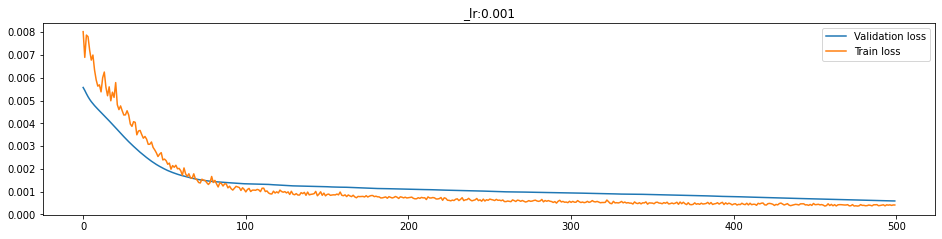

<Figure size 432x288 with 0 Axes>

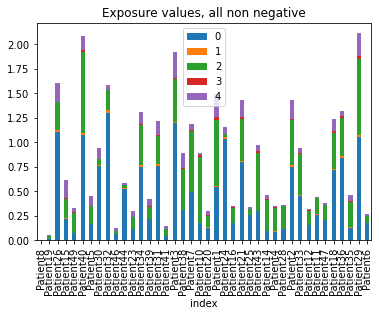

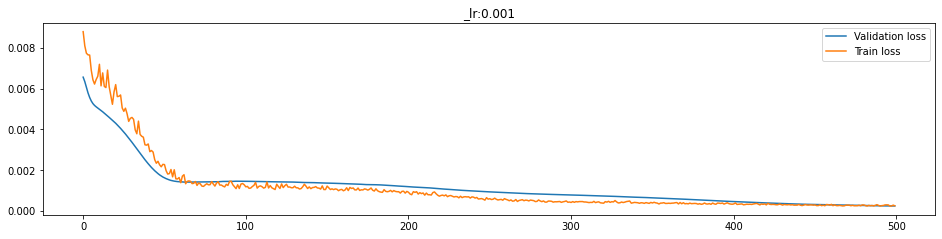

<Figure size 432x288 with 0 Axes>

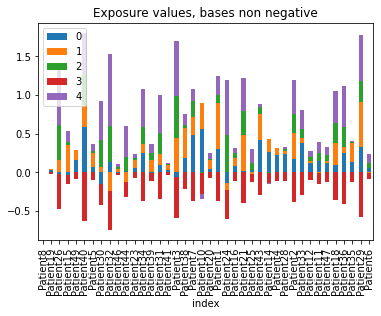

In [17]:
nsigs = 5

#np.random.seed(20)
#random.seed(20)
mf_df, true_sigs,_ = simulate_counts(nsigs,50, pentanucelotide=False)
tri = mf_df.index
mutation = [t[2:5] for t in tri]

#X = (mf_df / mf_df.sum(axis=0)).T
X = mf_df.T/mf_df.max().max()


#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model_all = AAUtoSig(96, nsigs)
model_dec = AAUtoSig(96, nsigs)


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_all = torch.optim.Adam(model_all.parameters(),
                            lr = 1e-3)
optimizer_dec = torch.optim.Adam(model_dec.parameters(),
                            lr = 1e-3)
# ------------------------------------------- NON-NEGATIVE = ALL ---------------------------------
                            
_,val_loss_all, train_loss_all = train_AAUtoSig(epochs = 500, 
                                        model = model_all, 
                                        x_train = x_train,
                                        x_test = x_val, 
                                        criterion = loss_function, 
                                        optimizer = optimizer_all,
                                        batch_size = 16,
                                        do_plot = True, 
                                        ES = False, 
                                        i = None, 
                                        non_negative = "all")




#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_all = model_all.dec1.weight.data
exp_all = pd.DataFrame(x_train@model_all.enc1.weight.data.T)
exp_all['index'] = exp_all.index
exp_all.plot(x = 'index', kind = 'bar', stacked = 'False', title = "Exposure values, all non negative")
sigs_all = pd.DataFrame(sigs_all.numpy()) 


# ------------------------------------------- NON-NEGATIVE = DEC ---------------------------------
                            
_,val_loss_dec, train_loss_dec = train_AAUtoSig(epochs = 500, 
                                        model = model_dec, 
                                        x_train = x_train,
                                        x_test = x_val, 
                                        criterion = loss_function, 
                                        optimizer = optimizer_dec,
                                        batch_size=16,
                                        do_plot = True, 
                                        ES = False, 
                                        i = None, 
                                        non_negative = "bases")




#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_dec = model_dec.dec1.weight.data  
exp_dec = pd.DataFrame(x_train@model_dec.enc1.weight.data.T)
exp_dec['index'] = exp_dec.index
exp_dec.plot(x = 'index', kind = 'bar', stacked = 'False', title = "Exposure values, bases non negative")
sigs_dec = pd.DataFrame(sigs_dec.numpy())

In [18]:
mat_all, perm_all = cosine_HA(sigs_all.T,true_sigs.T)
sigs_all = sigs_all[perm_all]
print("Mean cosine distance when all parameters are non negative")
print(np.mean(mat_all.diagonal()))

mat_dec, perm_dec = cosine_HA(sigs_dec.T,true_sigs.T)
sigs_dec = sigs_dec[perm_dec]
print("Mean cosine distance when decoder is non negative")
print(np.mean(mat_dec.diagonal()))

Mean cosine distance when all parameters are non negative
0.7170637689127185
Mean cosine distance when decoder is non negative
0.676371427518409


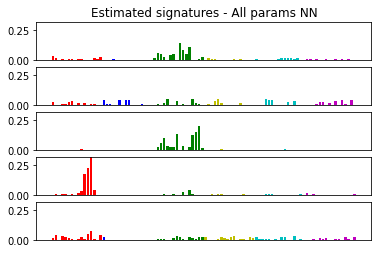

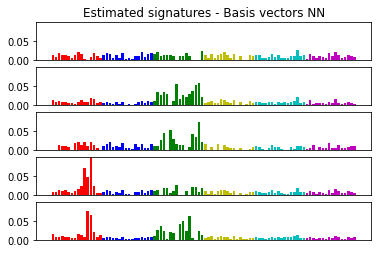

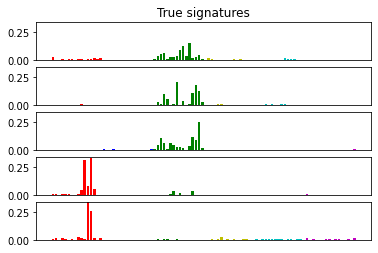

In [19]:
#plot the results
plotsigs(tri, sigs_all.to_numpy(), nsigs, "Estimated signatures - All params NN")  
plotsigs(tri, sigs_dec.to_numpy(), nsigs, "Estimated signatures - Basis vectors NN")
plotsigs(tri, true_sigs.to_numpy(), nsigs, "True signatures")  